In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud
import re
import string
import unicodedata

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from yellowbrick.classifier import ROCAUC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salmanabdu/tokopedia-product-reviews-2025")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'tokopedia-product-reviews-2025' dataset.
Path to dataset files: /kaggle/input/tokopedia-product-reviews-2025
['tokopedia_product_reviews_2025.csv']


## load data

In [3]:
df = pd.read_csv(path + '/tokopedia_product_reviews_2025.csv')
df.head()

,review_text,review_date,review_id,product_name,product_category,product_variant,product_price,product_url,product_id,rating,sold_count,shop_id,sentiment_label
0,baru sekali ini terima brg dr belanja online d...,2024-12-22,1134256160,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
1,cocok bgt aku sama telur nya. nga Amis menurut...,2025-02-25,1242584634,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
2,Telornya sudah sampai di rumah dengan kemasan ...,2025-07-15,1573444677,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
3,Telor sudah diterima dengan baik dan tidak ada...,2025-07-20,1581728541,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",2023-04-24,881041355,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Full Design,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive


In [4]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65543 entries, 0 to 65542
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_text       65543 non-null  object
 1   review_date       65543 non-null  object
 2   review_id         65543 non-null  int64 
 3   product_name      65543 non-null  object
 4   product_category  65543 non-null  object
 5   product_variant   26749 non-null  object
 6   product_price     65543 non-null  int64 
 7   product_url       65543 non-null  object
 8   product_id        65543 non-null  int64 
 9   rating            65543 non-null  int64 
 10  sold_count        65543 non-null  int64 
 11  shop_id           65543 non-null  int64 
 12  sentiment_label   65543 non-null  object
dtypes: int64(6), object(7)
memory usage: 6.5+ MB


,0
review_text,0
review_date,0
review_id,0
product_name,0
product_category,0
product_variant,38794
product_price,0
product_url,0
product_id,0
rating,0


drop columns

In [5]:
df = df.drop(columns=
 ['review_id',
  'review_date',
  'product_name',
  'product_category',
  'product_variant',
  'product_price',
  'product_url',
  'product_id',
  'rating',
  'sold_count',
  'shop_id'])

df.head()

,review_text,sentiment_label
0,baru sekali ini terima brg dr belanja online d...,positive
1,cocok bgt aku sama telur nya. nga Amis menurut...,positive
2,Telornya sudah sampai di rumah dengan kemasan ...,positive
3,Telor sudah diterima dengan baik dan tidak ada...,positive
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",positive


In [6]:
df['review_len'] = df['review_text'].apply(lambda x: len(x.split(' ')))
df.head()

,review_text,sentiment_label,review_len
0,baru sekali ini terima brg dr belanja online d...,positive,34
1,cocok bgt aku sama telur nya. nga Amis menurut...,positive,20
2,Telornya sudah sampai di rumah dengan kemasan ...,positive,16
3,Telor sudah diterima dengan baik dan tidak ada...,positive,13
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",positive,18


## EDA

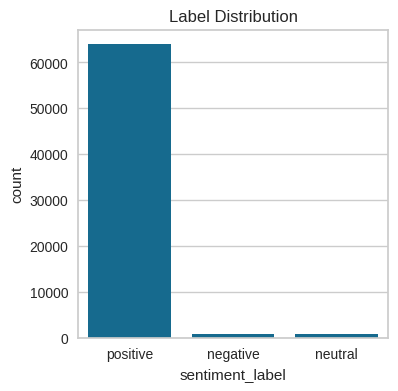

,count
sentiment_label,
positive,63943
neutral,802
negative,798


In [7]:
plt.figure(figsize=(4, 4))
sns.countplot(x='sentiment_label', data=df)
plt.title('Label Distribution')
plt.show()

df.sentiment_label.value_counts()

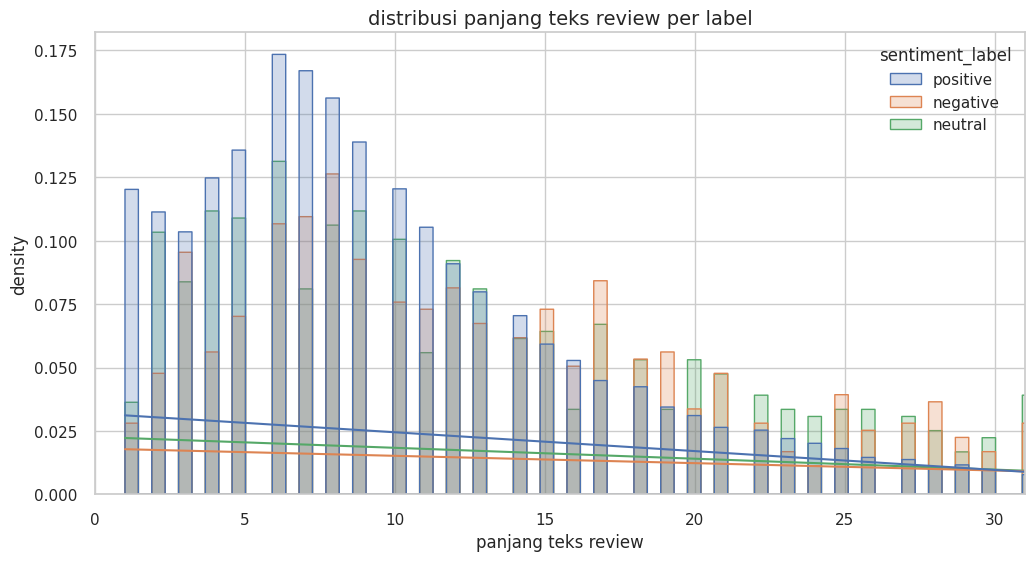

In [8]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='review_len', hue='sentiment_label',
             kde=True, element="step", stat="density", common_norm=False)

limit_x = df['review_len'].quantile(0.95)
plt.xlim(0, limit_x)

plt.title('distribusi panjang teks review per label', fontsize=14)
plt.xlabel('panjang teks review', fontsize=12)
plt.ylabel('density', fontsize=12)

plt.show()

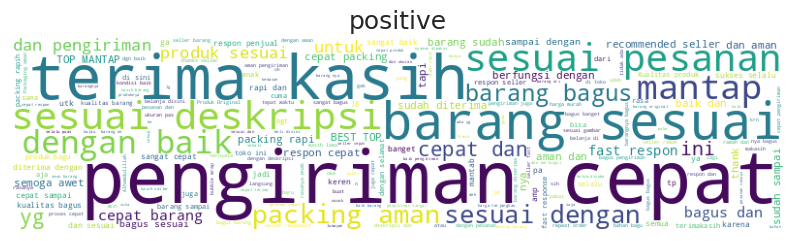

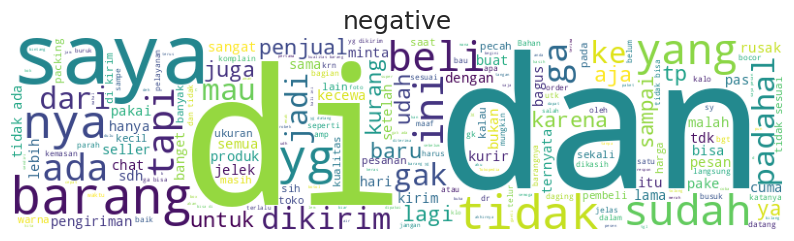

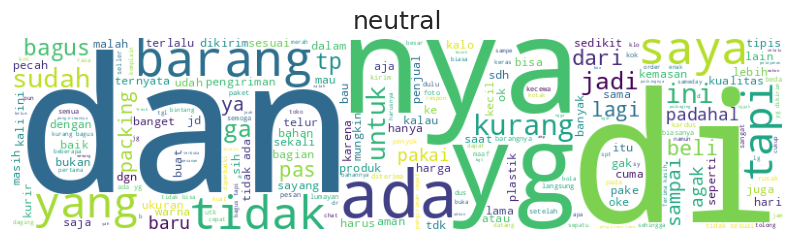

In [9]:
def generate_wc(df, sentiment, text_col='review_text'):
    wc = WordCloud(background_color='white', width=800)

    text_data = df.loc[df['sentiment_label'] == sentiment, text_col]

    wc.generate(' '.join(text_data.astype(str)))

    plt.figure(figsize=(10, 6))
    plt.title(f'{sentiment}', fontdict={'size': 18})
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

for label in ['positive', 'negative', 'neutral']:
    generate_wc(df, label)

## Preprocess

cleaning review text

In [10]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [11]:
def remove_emoji(text):
  emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "]+",
        flags=re.UNICODE
    )

  return emoji_pattern.sub("", text)

In [12]:
slang = {
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "bgt": "banget",
    "bgus": "bagus",
    "mantul": "mantap",
    "mantab": "mantap",
    "tdk": "tidak",
    "yg": "yang",
    "dgn": "dengan",
    "krn": "karena",
    "jg": "juga",
    "sdh": "sudah",
    "sy": "saya",
    "tp": "tapi",
    "dr": "dari",
    "brg": "barang"
}

def normalize_slang(text):
  tokens = text.split()
  tokens = [slang.get(word, word) for word in tokens]
  return " ".join(tokens)

In [13]:
def cleaning_text(text):
    text = clean_text(text)
    text = remove_emoji(text)
    text = normalize_slang(text)
    return text

df["clean_review"] = df["review_text"].apply(cleaning_text)
df.head()

,review_text,sentiment_label,review_len,clean_review
0,baru sekali ini terima brg dr belanja online d...,positive,34,baru sekali ini terima barang dari belanja onl...
1,cocok bgt aku sama telur nya. nga Amis menurut...,positive,20,cocok banget aku sama telur nya nga amis menur...
2,Telornya sudah sampai di rumah dengan kemasan ...,positive,16,telornya sudah sampai di rumah dengan kemasan ...
3,Telor sudah diterima dengan baik dan tidak ada...,positive,13,telor sudah diterima dengan baik dan tidak ada...
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",positive,18,alhamdulillah penjual amanahtelor nya terbaiks...


Stopwords BINDO

In [14]:
!pip install Sastrawi

In [15]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

def remove_stopwords(text):
  return " ".join(
      [word for word in str(text).split() if word not in stopwords]
  )

df['clean_review'] = df['clean_review'].apply(remove_stopwords)
df.head()

,review_text,sentiment_label,review_len,clean_review
0,baru sekali ini terima brg dr belanja online d...,positive,34,baru sekali terima barang belanja online dg pa...
1,cocok bgt aku sama telur nya. nga Amis menurut...,positive,20,cocok banget aku sama telur nya nga amis menur...
2,Telornya sudah sampai di rumah dengan kemasan ...,positive,16,telornya rumah kemasan sangat rapi luar biasa ...
3,Telor sudah diterima dengan baik dan tidak ada...,positive,13,telor diterima baik pecah terimakasih buat sel...
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",positive,18,alhamdulillah penjual amanahtelor nya terbaiks...


lemmatizer

In [16]:
lemmatizer = nltk.WordNetLemmatizer()

def lem_text(text):
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  return text

df['clean_review'] = df['clean_review'].apply(lem_text)
df.head()

,review_text,sentiment_label,review_len,clean_review
0,baru sekali ini terima brg dr belanja online d...,positive,34,baru sekali terima barang belanja online dg pa...
1,cocok bgt aku sama telur nya. nga Amis menurut...,positive,20,cocok banget aku sama telur nya nga amis menur...
2,Telornya sudah sampai di rumah dengan kemasan ...,positive,16,telornya rumah kemasan sangat rapi luar biasa ...
3,Telor sudah diterima dengan baik dan tidak ada...,positive,13,telor diterima baik pecah terimakasih buat sel...
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",positive,18,alhamdulillah penjual amanahtelor nya terbaiks...


encoder

In [17]:
le = LabelEncoder()
le.fit(df['sentiment_label'])

df['sentiment_label'] = le.transform(df['sentiment_label'])
df.head()

,review_text,sentiment_label,review_len,clean_review
0,baru sekali ini terima brg dr belanja online d...,2,34,baru sekali terima barang belanja online dg pa...
1,cocok bgt aku sama telur nya. nga Amis menurut...,2,20,cocok banget aku sama telur nya nga amis menur...
2,Telornya sudah sampai di rumah dengan kemasan ...,2,16,telornya rumah kemasan sangat rapi luar biasa ...
3,Telor sudah diterima dengan baik dan tidak ada...,2,13,telor diterima baik pecah terimakasih buat sel...
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",2,18,alhamdulillah penjual amanahtelor nya terbaiks...


visualisasi token

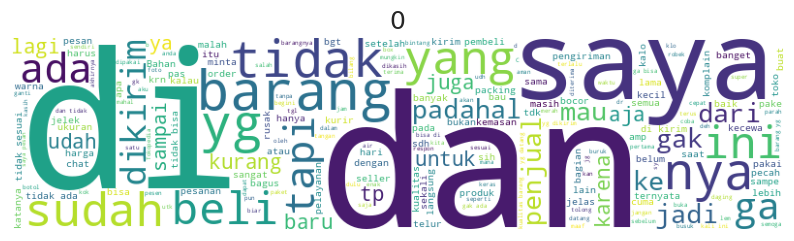

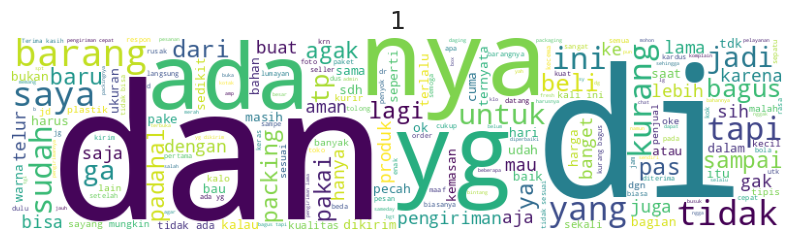

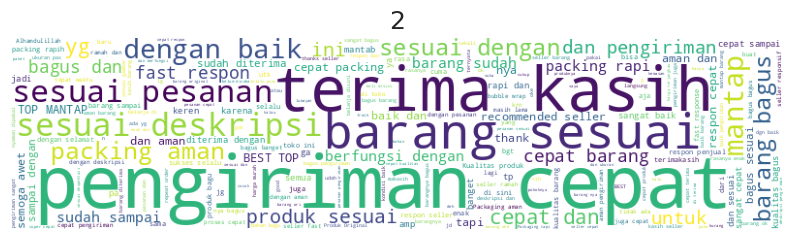

In [18]:
def generate_wc(df, sentiment, text_col='review_text'):
    wc = WordCloud(background_color='white', width=800)

    text_data = df.loc[df['sentiment_label'] == sentiment, text_col]

    wc.generate(' '.join(text_data.astype(str)))

    plt.figure(figsize=(10, 6))
    plt.title(f'{sentiment}', fontdict={'size': 18})
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

for label in [0, 1, 2]:
    generate_wc(df, label)

## train model

In [19]:
X = df['clean_review']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

#### BoW

In [20]:
vector_bow = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_bow = vector_bow.fit_transform(X_train)
X_test_bow = vector_bow.transform(X_test)

In [21]:
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)

MultinomialNB()

In [22]:
y_pred_bow = nb_bow.predict(X_test_bow)
y_proba_bow = nb_bow.predict_proba(X_test_bow)[:, 1]

akurasi = accuracy_score(y_test, y_pred_bow)
f1 = f1_score(y_test, y_pred_bow, average='weighted')
precision = precision_score(y_test, y_pred_bow, average='weighted')
recall = recall_score(y_test, y_pred_bow, average='weighted')

print(f'Akurasi: {akurasi:.3f}')
print(f'f1 : {f1:.3f}')
print(f'precision : {precision:.3f}')
print(f'recall : {recall:.3f}')

Akurasi: 0.940
f1 : 0.951
precision : 0.965
recall : 0.940


In [23]:
cr = classification_report(y_test, y_pred_bow)
print(cr)

              precision    recall  f1-score   support

           0       0.21      0.45      0.28       163
           1       0.09      0.20      0.13       173
           2       0.99      0.96      0.97     12773

    accuracy                           0.94     13109
   macro avg       0.43      0.54      0.46     13109
weighted avg       0.97      0.94      0.95     13109



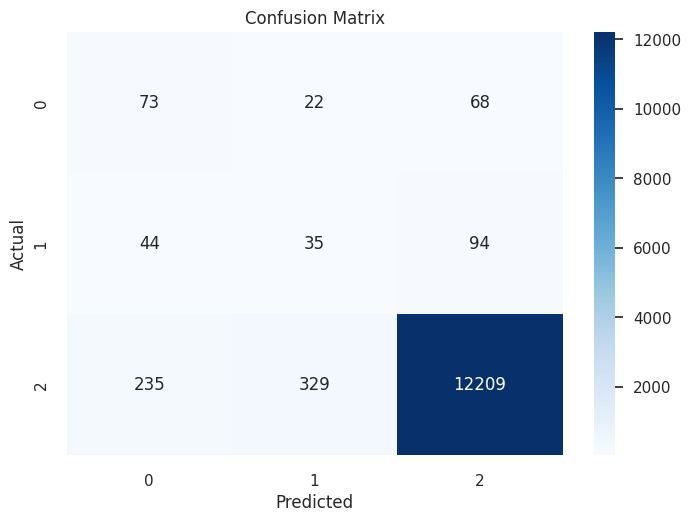

In [24]:
cm = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

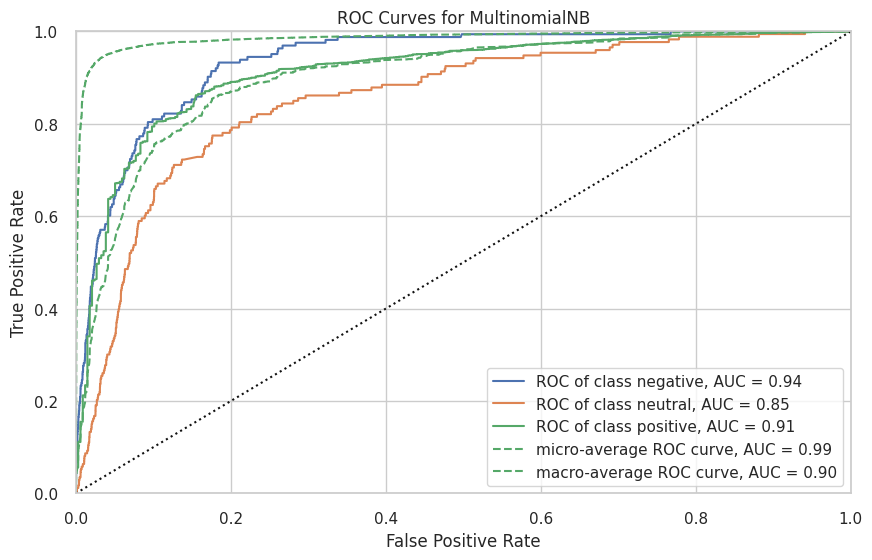

In [25]:
plt.figure(figsize=(10, 6))

visualizer = ROCAUC(nb_bow, classes=['negative', 'neutral', 'positive'])

visualizer.fit(X_train_bow, y_train)
visualizer.score(X_test_bow, y_test)
visualizer.show()
plt.show()

#### TF-IDF

In [26]:
vector_tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = vector_tfidf.fit_transform(X_train)
X_test_tfidf = vector_tfidf.transform(X_test)

In [27]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [28]:
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
y_proba_tfidf = nb_tfidf.predict_proba(X_test_bow)[:, 1]

akurasi = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf, average='weighted')
precision = precision_score(y_test, y_pred_tfidf, average='weighted')
recall = recall_score(y_test, y_pred_tfidf, average='weighted')

print(f'Akurasi: {akurasi:.3f}')
print(f'f1 : {f1:.3f}')
print(f'precision : {precision:.3f}')
print(f'recall : {recall:.3f}')

Akurasi: 0.974
f1 : 0.962
precision : 0.955
recall : 0.974


In [29]:
cr = classification_report(y_test, y_pred_tfidf)

print(cr)

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       163
           1       0.00      0.00      0.00       173
           2       0.97      1.00      0.99     12773

    accuracy                           0.97     13109
   macro avg       0.46      0.34      0.34     13109
weighted avg       0.95      0.97      0.96     13109



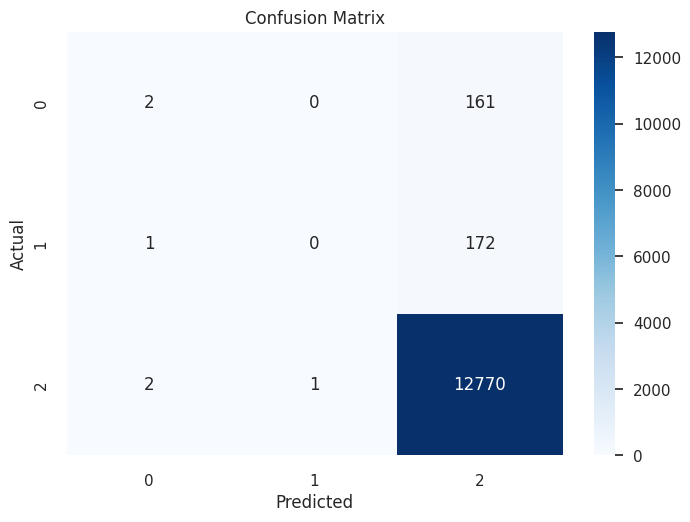

In [30]:
cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

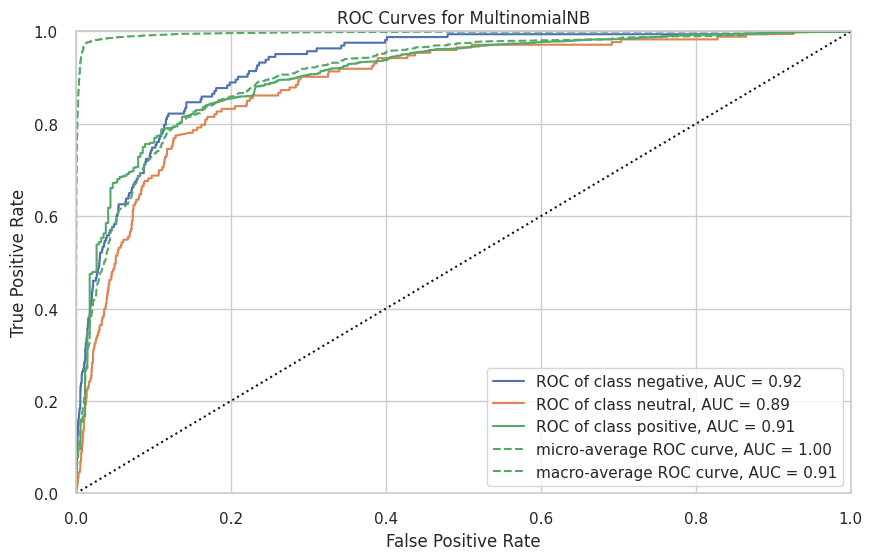

In [31]:
plt.figure(figsize=(10, 6))

visualizer = ROCAUC(nb_tfidf, classes=['negative', 'neutral', 'positive'])

visualizer.fit(X_train_tfidf, y_train)
visualizer.score(X_test_tfidf, y_test)
visualizer.show()
plt.show()